<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Optimizing_Component_Selection_for_Enhanced_Correlation_Analysis_in_fMRI_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **_Synopsis_**
**Diving into fMRI data components**, we harness parallel computing to swiftly and efficiently unravel their intricate correlations.


# Component Analysis of Resting-State fMRI Data

## Decomposition of Data
The functional magnetic resonance imaging (fMRI) data is subjected to a specialized decomposition process. This process aims to uncover the underlying spatial patterns, known as 'components', embedded within the data. The extracted components can further provide insights into neural activations and their spatial relationships.

### Low-Order and High-Order Components
A unique aspect of our investigation involves categorizing the extracted components into two distinct groups: 'low-order' and 'high-order'. These classifications are essential to understanding the hierarchical relationships and functional connectivity within the data.

## Peak Voxel Identification and Analysis
* **Peak Voxel Definition**: Within each component, a voxel with the highest activity is termed as the 'peak voxel'. Identifying these peak voxels provides key insights into regions of most pronounced neural activation.
* **Peak Voxel Coordinates**: The spatial coordinates of the peak voxels are determined for detailed analysis.

## Anatomical Proximity and Overlap Analysis
* **Distance Measurement**: The spatial relationship between components is measured by calculating the Euclidean distance between their corresponding peak voxels.
* **Proximity Thresholding**: By applying a predetermined distance threshold, we identify pairs of components from the low-order and high-order groups that are anatomically proximate. This thresholded analysis guides further investigation into the intricate spatial relationships existing within the fMRI data.


# Pearson Correlation of Anatomically Proximal Components

## Selection Criteria for Component Pairing
* **Dual-Level Correlation Analysis**: For every component in the low-order group, a systematic correlation assessment with each high-order component is undertaken.
* **Anatomical Proximity Filtering**: Prior to the correlation computation, an essential criterion is established based on the anatomical proximity of their peak voxels. Component pairs failing this spatial proximity check are disregarded in subsequent analyses.

## Filter Statistically Significant Correlations
* **Correlation Significance**: Post-correlation computation, we subject the results to rigorous statistical validation to ascertain their significance.
* **Significance Threshold**: Correlations are meticulously filtered, with only those exhibiting significance levels below a predetermined alpha value being retained for further investigation.

## Efficient Computation through Parallelization
* **Need for Speed**: Given the computationally intensive nature of our analyses, we've employed advanced computational strategies.
* **Distributed Processing**: By leveraging parallel processing techniques, we distribute the correlation computation tasks across multiple processing units. This parallelization ensures a more efficient and timely execution of calculations.


In [60]:
!pip install -q nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import plotting, image
from scipy.stats import pearsonr
from nilearn import datasets, image
import matplotlib.pyplot as plt

## Grid Search for Optimal N Components by Anatomic Proximity

Enter the minimum value for the range: 5
Enter the maximum value for the range: 20
Enter the significance level (default is 0.05): 0.01

The anatomical overlap threshold determines how close the peak voxels of two components should be to consider them as overlapping. A smaller value means they must be very close, while a larger value allows for greater distances. The value is in voxels.
Enter the anatomical overlap threshold (default is 5 voxels): 1


Calculating Correlations: 100%|███████████████████████████████████████| 6/6 [01:19<00:00, 13.22s/it]



Average time per combination: 13.22s
Estimated total time: 79.34s
Optimal N-low: 15, N-high: 20, with cumulative r: 13.107


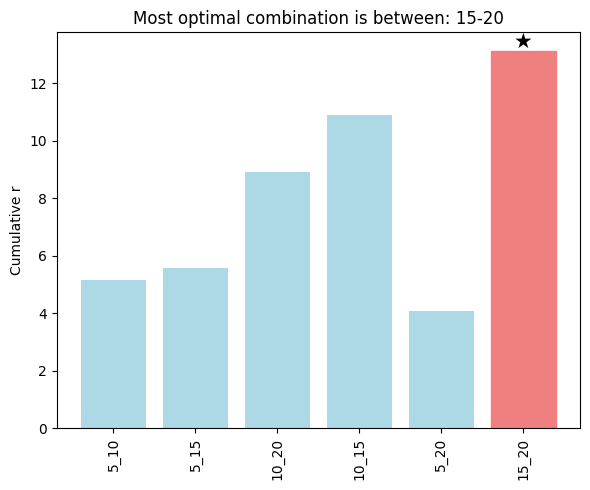

In [71]:
import numpy as np
import warnings
import time
import concurrent.futures
from tqdm import tqdm
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

class ComponentCorrelationCalculator:
    """Calculate and analyze the correlation between components of fMRI data."""

    def __init__(self, n_low_order, n_high_order, func_filenames, alpha=0.05, distance_threshold=5):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.func_filenames = func_filenames
        self.alpha = alpha
        self.distance_threshold = distance_threshold

    def _get_peak_coordinates(self, component):
        """Get the coordinates of the peak (maximum value) of the component."""
        max_val_index = np.unravel_index(np.argmax(component), component.shape)
        return max_val_index

    def _anatomical_overlap(self, comp1, comp2):
        """Check if two components have peaks in a proximal location."""
        peak1 = self._get_peak_coordinates(comp1)
        peak2 = self._get_peak_coordinates(comp2)

        distance = np.linalg.norm(np.array(peak1) - np.array(peak2))

        return distance < self.distance_threshold

    def _decompose(self, n_components):
        dict_learn = DictLearning(n_components=n_components, random_state=0)
        return dict_learn.fit_transform(self.func_filenames)

    def perform_decomposition(self):
        self.components_img_low = self._decompose(self.n_low_order)
        self.components_img_high = self._decompose(self.n_high_order)

    def compute_correlation_matrix(self):
        matrix = np.zeros((self.n_low_order, self.n_high_order))

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]

                if not self._anatomical_overlap(data_low, data_high):
                    continue

                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                if p_value < self.alpha:
                    matrix[i, j] = correlation

        return np.nan_to_num(matrix)

    def calculate_component_correlation(self):
        self.perform_decomposition()
        correlation_matrix = self.compute_correlation_matrix()
        positive_r = correlation_matrix[correlation_matrix > 0].sum()
        return self.n_low_order, self.n_high_order, positive_r

def optimize_components(n_low_range, n_high_range, func_filenames, alpha, distance_threshold):
    best_values = {"n_low": None, "n_high": None, "cumulative_r": -np.inf}
    results = []

    valid_combinations = [(n_low, n_high) for n_low in n_low_range for n_high in n_high_range if n_high > n_low]
    total_combinations = len(valid_combinations)

    # Suppress constant input warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=stats.ConstantInputWarning)

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [executor.submit(ComponentCorrelationCalculator(n_low, n_high, func_filenames, alpha, distance_threshold).calculate_component_correlation) for n_low, n_high in valid_combinations]

            progress_bar = tqdm(total=total_combinations, desc="Calculating Correlations", ncols=100)  # Initialize the tqdm progress bar

            start_time = time.time()
            for future in concurrent.futures.as_completed(futures):
                n_low, n_high, positive_r = future.result()
                results.append((f"{n_low}_{n_high}", positive_r))
                if positive_r > best_values["cumulative_r"]:
                    best_values = {"n_low": n_low, "n_high": n_high, "cumulative_r": positive_r}

                progress_bar.update(1)  # Manually update the tqdm progress bar

            elapsed_time = time.time() - start_time
            avg_time_per_combination = elapsed_time / total_combinations

            progress_bar.close()  # Close the tqdm progress bar

            print(f"\nAverage time per combination: {avg_time_per_combination:.2f}s")
            print(f"Estimated total time: {elapsed_time:.2f}s")

    return best_values, results

def plot_results(results, best_combo, min_value, max_value):
    labels, values = zip(*results)
    max_value_result = max(values)
    max_idx = values.index(max_value_result)

    number_of_combinations = max_value - min_value + 1
    fig_width = 5 + number_of_combinations // 10

    plt.figure(figsize=(fig_width, 5))
    bars = plt.bar(labels, values, color='lightblue')
    bars[max_idx].set_color('lightcoral')
    plt.xticks(rotation=90)
    plt.annotate('★', (max_idx, max_value_result + 0.1), ha='center', color='black', fontsize=15)
    plt.ylabel('Cumulative r')
    plt.title(f'Most optimal combination is between: {best_combo}')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    min_value = int(input("Enter the minimum value for the range: "))
    max_value = int(input("Enter the maximum value for the range: "))
    alpha = float(input("Enter the significance level (default is 0.05): ") or "0.05")

    # Explanation and prompt for anatomical overlap threshold
    print("\nThe anatomical overlap threshold determines how close the peak voxels of two components should be "
          "to consider them as overlapping. A smaller value means they must be very close, while a larger value "
          "allows for greater distances. The value is in voxels.")
    distance_threshold = int(input("Enter the anatomical overlap threshold (default is 5 voxels): ") or "5")

    n_low_range = range(min_value, max_value + 1, 5)
    n_high_range = n_low_range

    adhd_dataset = datasets.fetch_adhd(n_subjects=1)

    best_values, results = optimize_components(n_low_range, n_high_range, adhd_dataset.func, alpha, distance_threshold)
    print(f"Optimal N-low: {best_values['n_low']}, N-high: {best_values['n_high']}, with cumulative r: {best_values['cumulative_r']:.3f}")
    plot_results(results, f"{best_values['n_low']}-{best_values['n_high']}", min_value, max_value)


## Hierarchical Clustering Between High- vs. Low-Order Component Dictionary Learning Decomposition
Top correlations:
* Low 28 and High 0

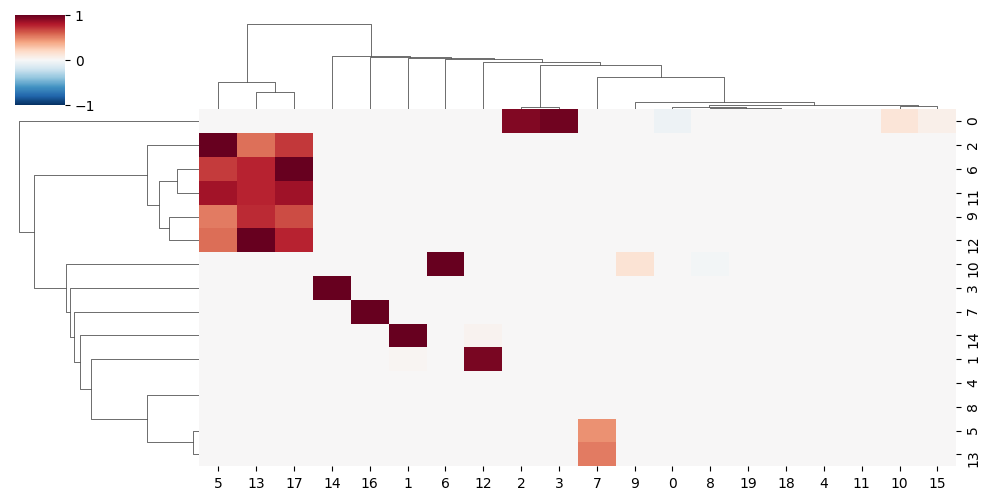

In [72]:
import numpy as np
from nilearn import datasets, decomposition
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib


class ComponentCorrelation:
    def __init__(self, n_low_order, n_high_order, memory_level=2, cache_dir="nilearn_cache"):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.cache_dir = cache_dir
        self.memory_level =  memory_level

    def _fetch_data(self):
        """Fetch sample functional data for testing."""
        dataset = datasets.fetch_adhd(n_subjects=1)
        self.func_filename = dataset.func

    def _perform_decomposition(self):
        options = {
            "random_state": 0,
            "memory": self.cache_dir,
            "memory_level": self.memory_level
        }

        dict_learn_low = decomposition.DictLearning(n_components=self.n_low_order, **options)
        dict_learn_high = decomposition.DictLearning(n_components=self.n_high_order, **options)

        self.components_img_low = dict_learn_low.fit_transform(self.func_filename)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filename)

    def _get_peak_coordinates(self, component):
        """Get the coordinates of the peak (maximum value) of the component."""
        # If the component is a Nifti1Image, extract its data, else assume it's a numpy array
        data = component.get_data() if isinstance(component, nib.Nifti1Image) else component
        max_val_index = np.unravel_index(np.argmax(data), data.shape)
        return max_val_index


    def _anatomical_overlap(self, comp1, comp2):
        """Check if two components have peaks in a proximal location."""
        peak1 = self._get_peak_coordinates(comp1)
        peak2 = self._get_peak_coordinates(comp2)

        distance = np.linalg.norm(np.array(peak1) - np.array(peak2))

        distance_threshold = 5  # adjust this value as necessary (this is in voxels)
        return distance < distance_threshold

    def _compute_correlation_matrix(self):
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.results = []

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]

                if not self._anatomical_overlap(data_low, data_high):
                    continue

                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                self.results.append({
                    'Low_Order_Component': i,
                    'High_Order_Component': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })
                self.correlation_matrix[i, j] = correlation

        # Handle invalid values
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    def _plot_heatmap(self):
        diverging_cmap = plt.cm.RdBu_r
        figsize = (10, 5)
        sns.clustermap(
            self.correlation_matrix,
            method="average",
            cmap=diverging_cmap,
            vmin=-1,
            vmax=1,
            annot=False,
            fmt=".2f",
            figsize=figsize
        )
        plt.show()

    def export_results_to_csv(self, filename="correlation_results.csv"):
        df = pd.DataFrame(self.results)
        df = df.sort_values(by='p_value')
        df.to_csv(filename, index=False)

    def visualize_component_correlation(self):
        self._fetch_data()
        self._perform_decomposition()
        self._compute_correlation_matrix()
        self._plot_heatmap()

if __name__ == "__main__":
    n_low_order = 15
    n_high_order = 20

    correlation_tool = ComponentCorrelation(n_low_order=n_low_order, n_high_order=n_high_order)
    correlation_tool.visualize_component_correlation()
    correlation_tool.export_results_to_csv()

## Anatomic Visualization of High- and Low-Order Component Dictionary Learning Decomposition


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


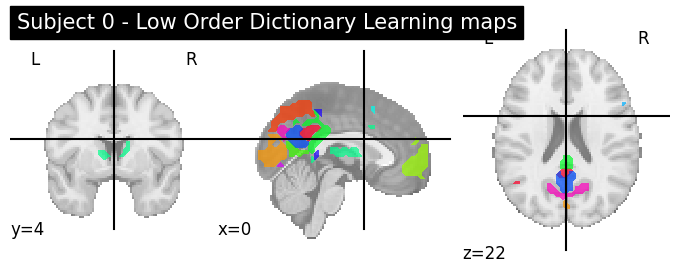

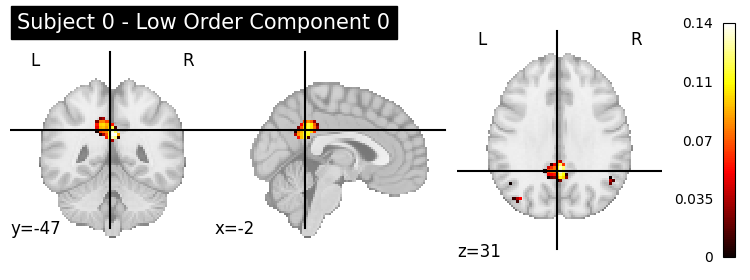

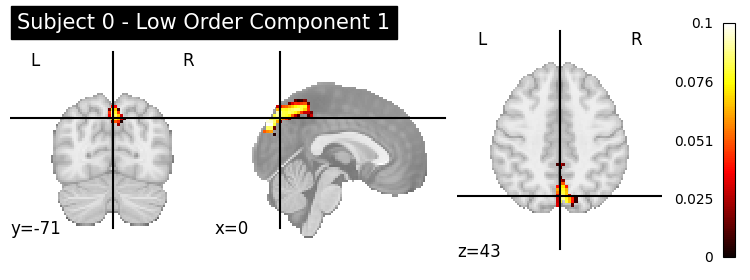

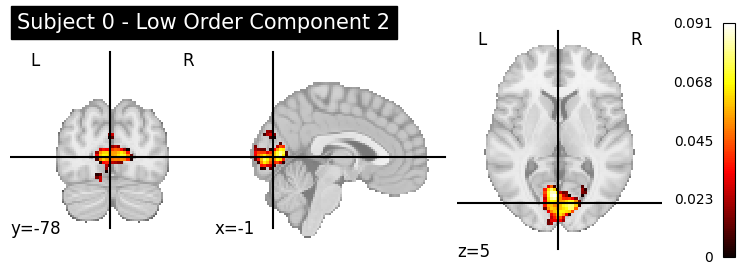

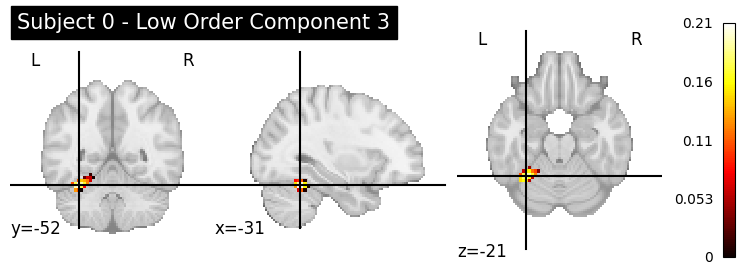

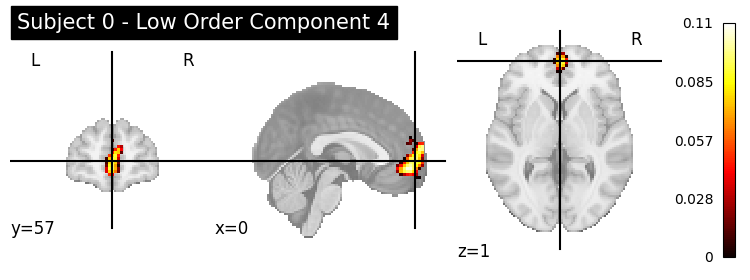

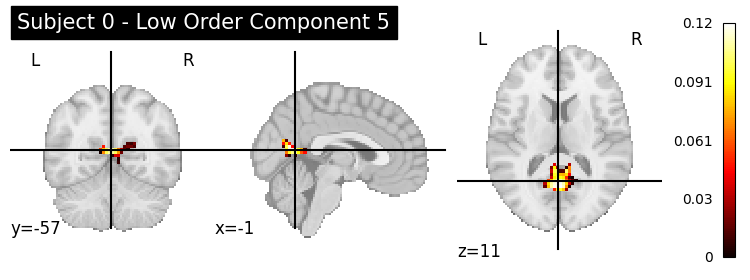

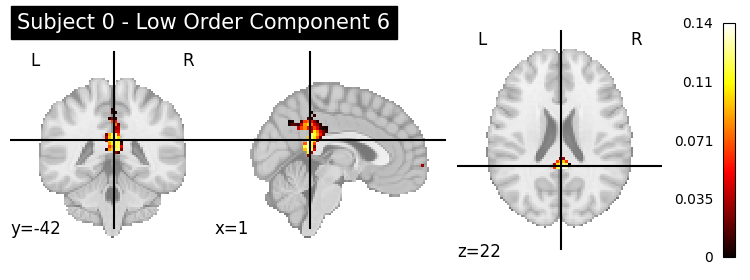

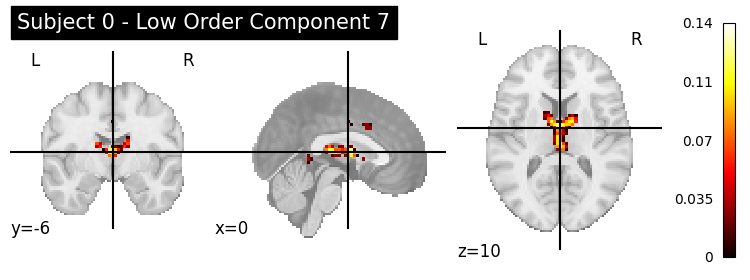

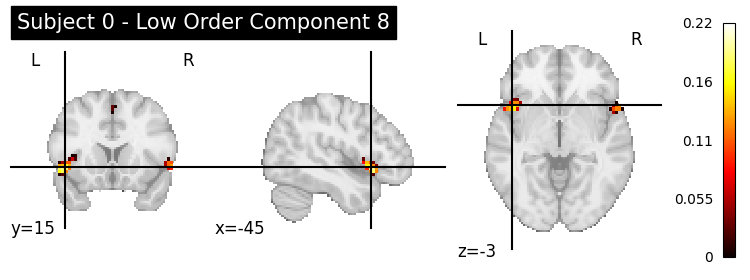

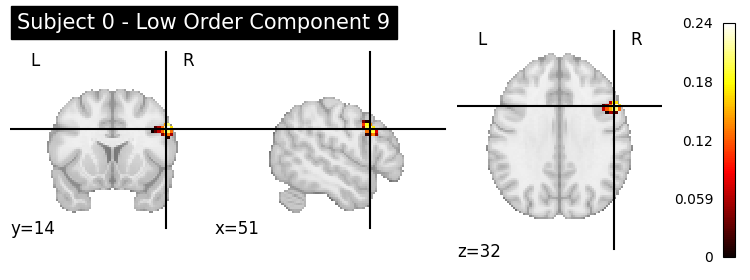

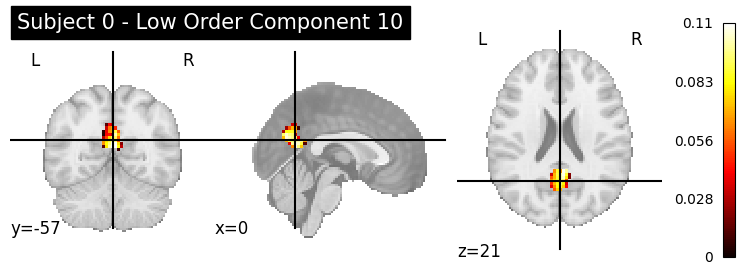

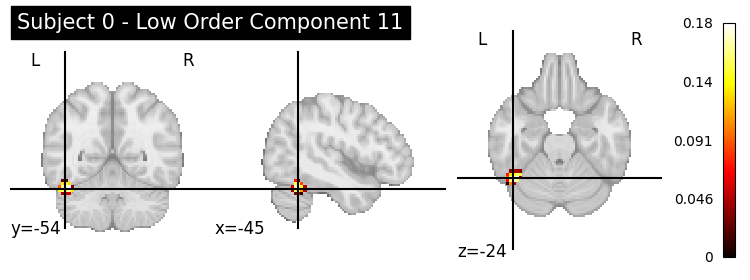

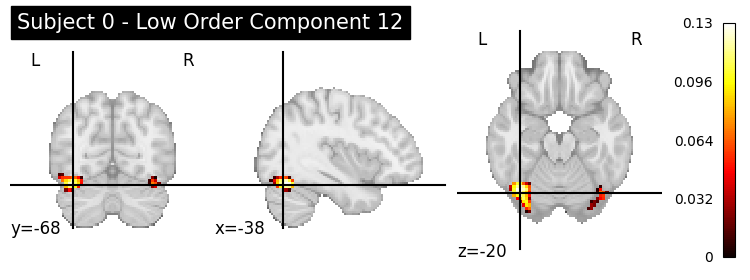

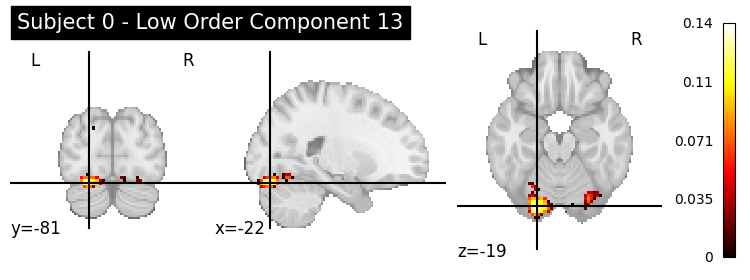

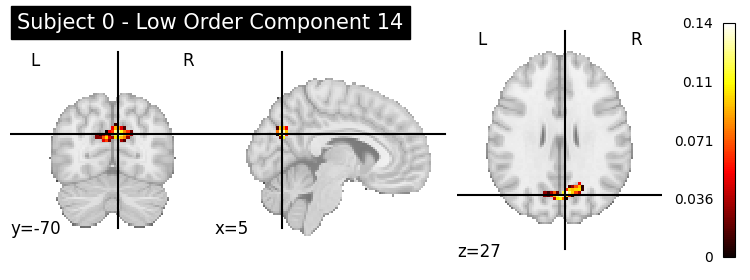

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


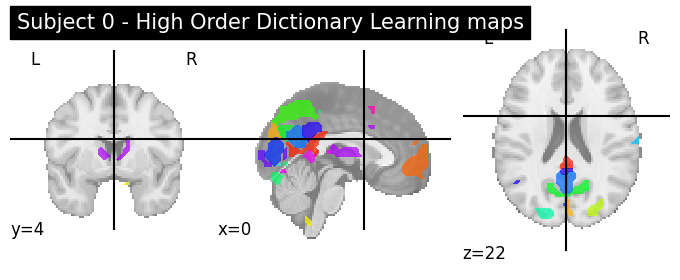

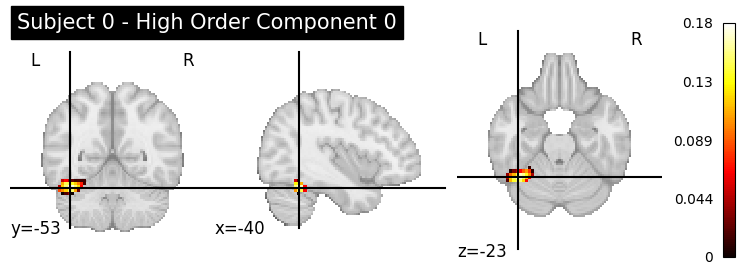

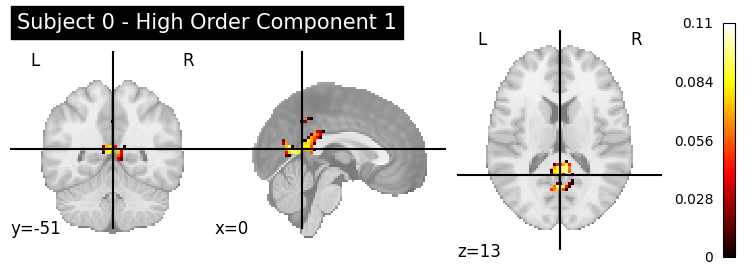

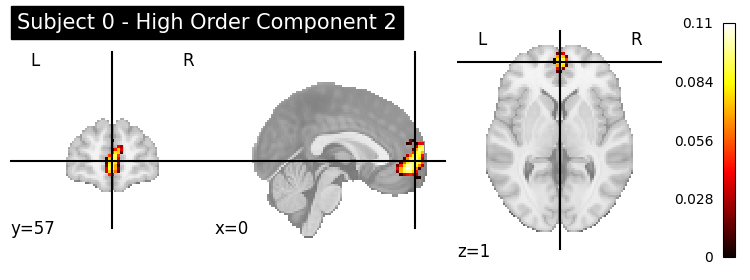

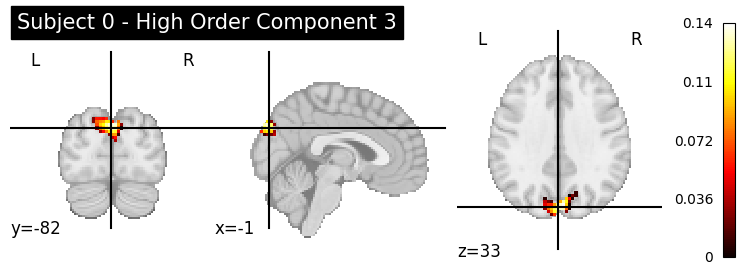

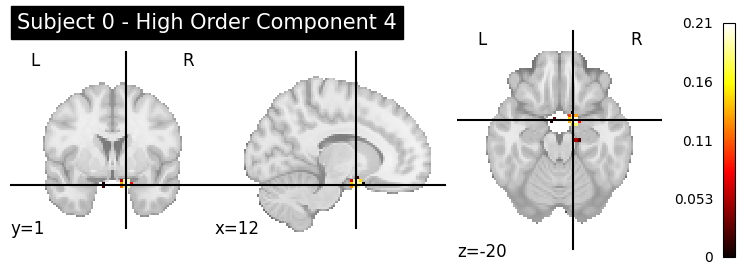

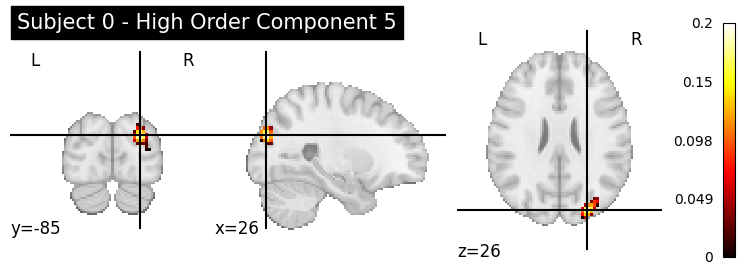

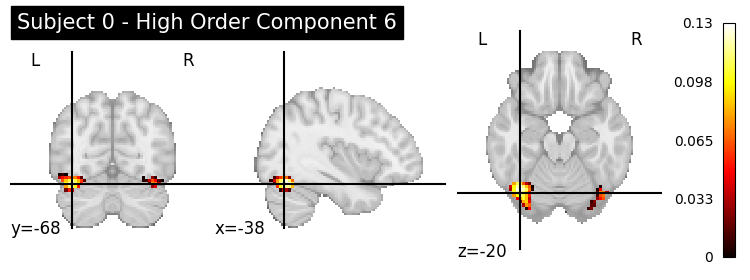

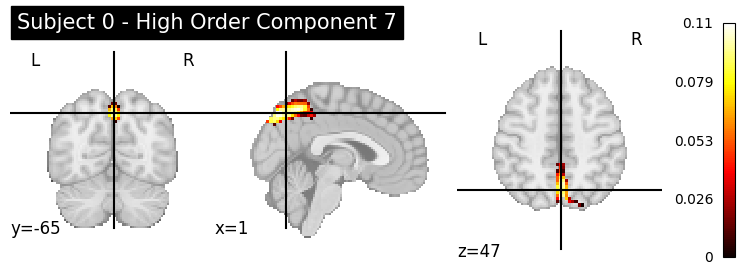

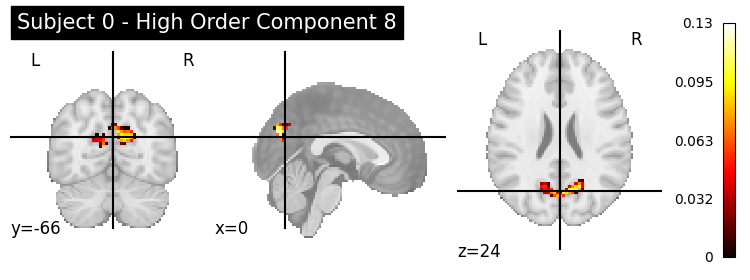

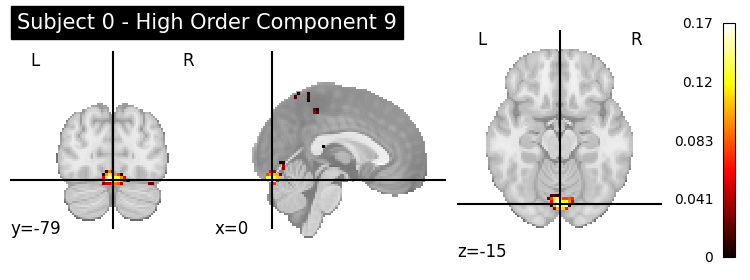

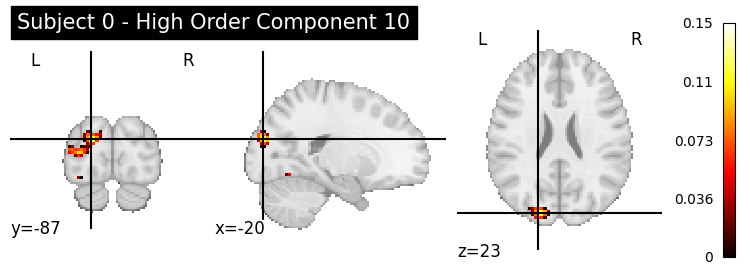

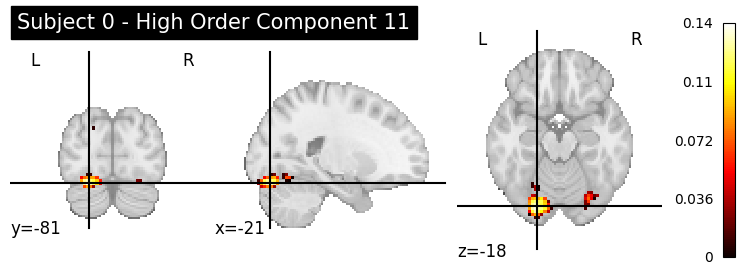

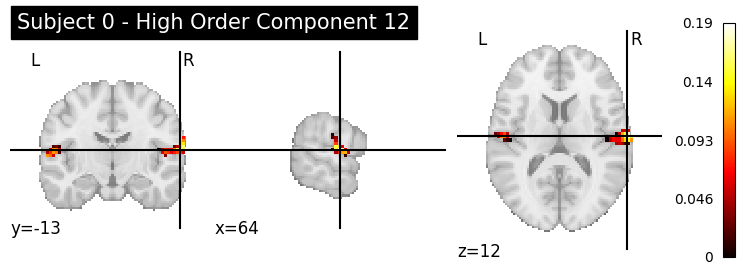

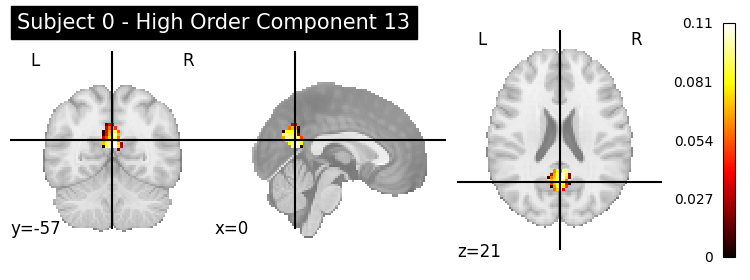

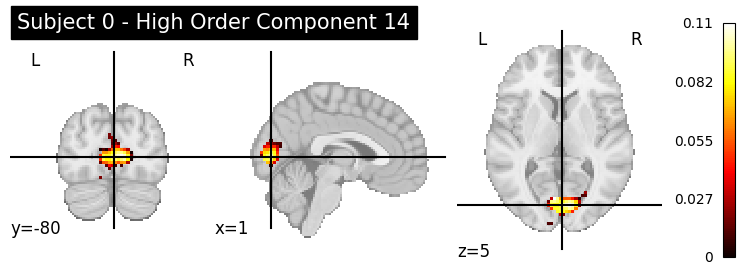

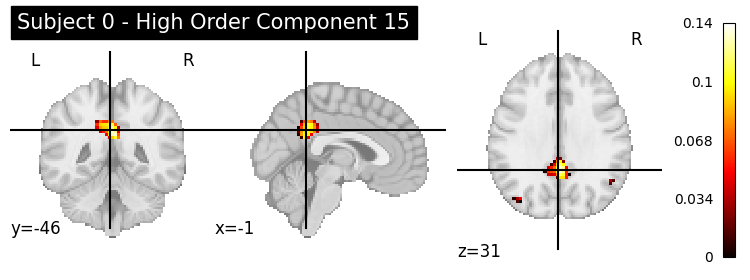

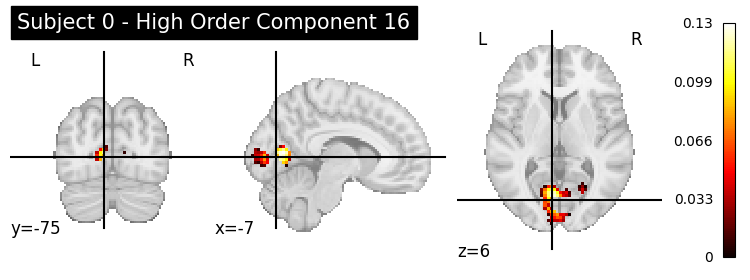

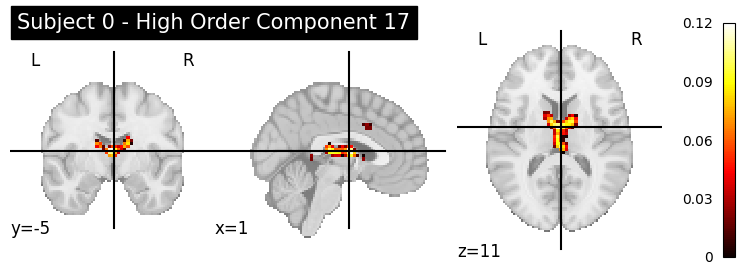

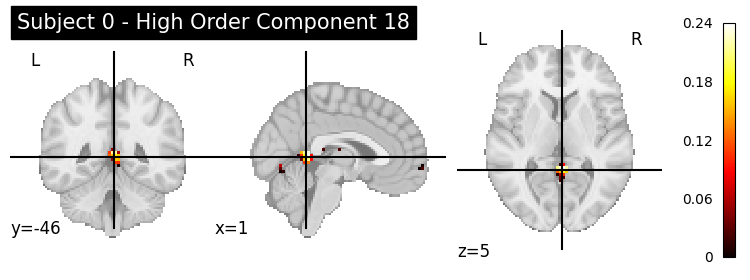

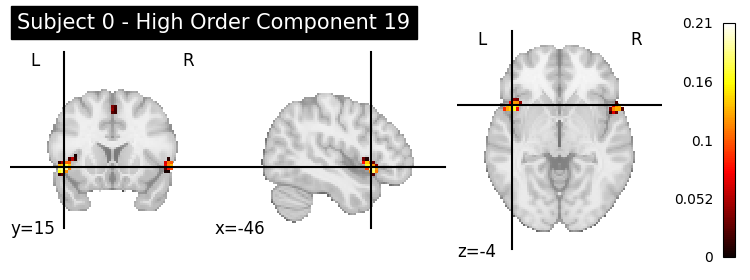

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_slicers.py:378: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


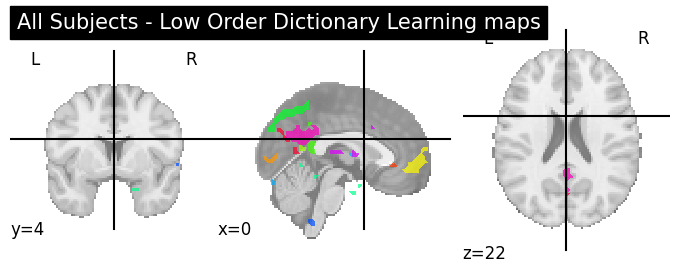

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_slicers.py:378: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


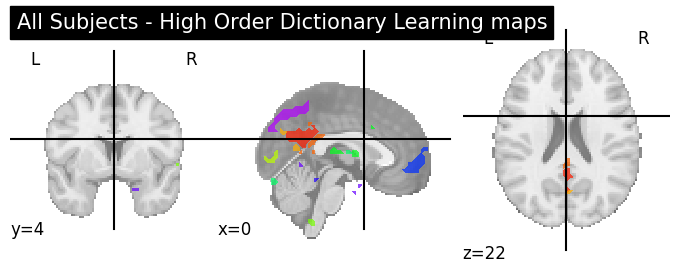

In [73]:
from nilearn import datasets, image, plotting
from nilearn.decomposition import DictLearning
from nilearn.image import concat_imgs

def apply_dictionary_learning_to_subject(func_file, n_components, fwhm, title_prefix):
    """Apply Dictionary Learning decomposition to a subject's fMRI data and visualize the components."""
    fmri_subject = image.smooth_img(func_file, fwhm=fwhm)
    dict_learn_subject = DictLearning(n_components=n_components, random_state=0)
    dict_learn_subject.fit(fmri_subject)

    components_img_subject = dict_learn_subject.components_img_

    # Visualize overall atlas and individual components
    plotting.plot_prob_atlas(components_img_subject, title=f'{title_prefix} Dictionary Learning maps')
    plotting.show()

    for j in range(n_components):
        component_img = image.index_img(components_img_subject, j)
        plotting.plot_stat_map(component_img, title=f'{title_prefix} Component {j}')
        plotting.show()

def apply_dictionary_learning_to_all(func_filenames, n_components, title_prefix):
    """Apply Dictionary Learning decomposition to concatenated fMRI data and visualize averaged components."""
    all_fmri = concat_imgs(func_filenames)

    dict_learn_all = DictLearning(n_components=n_components, random_state=0)
    dict_learn_all.fit(all_fmri)
    components_img_all = dict_learn_all.components_img_

    plotting.plot_prob_atlas(components_img_all, title=f'{title_prefix} Dictionary Learning maps')
    plotting.show()

if __name__ == "__main__":
    # Fetch the ADHD200 resting-state fMRI dataset
    n_subjects = 1
    adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
    func_filenames = adhd_dataset.func

    # Parameters
    low_order_components = 15
    high_order_components = 20
    fwhm = 6

    # Apply Dictionary Learning and visualize results for each subject
    for i, func_file in enumerate(func_filenames):
        title_prefix = f'Subject {i} - Low Order'
        apply_dictionary_learning_to_subject(func_file, low_order_components, fwhm, title_prefix)

        title_prefix = f'Subject {i} - High Order'
        apply_dictionary_learning_to_subject(func_file, high_order_components, fwhm, title_prefix)

    # Apply Dictionary Learning and visualize results for concatenated data
    apply_dictionary_learning_to_all(func_filenames, low_order_components, "All Subjects - Low Order")
    apply_dictionary_learning_to_all(func_filenames, high_order_components, "All Subjects - High Order")
